In [2]:

import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.13.0


In [3]:
#set directory for training and testing data
base_dir = '../data/fruits-360/'
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir) 

In [4]:
# Img size

img_height = 224
img_width = 224

In [5]:
# VGG16 Model 

# Data preprocessing - ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,# Image augmentaion 
    shear_range=0.2,
    zoom_range=0.2, # Zoom in on image by 20%
    horizontal_flip=True, #  Flip the image horizontally
    validation_split=0.2) # Split 20% of the data for validation

# Normalize the test data images
test_datagen = ImageDataGenerator(rescale=1./255) 
#flow_from_directory takes the directory containing the images, target size, 
# batch size, class mode as parameters

#Preprocess the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training') # Set as training data

#Preprocess validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir, # Same directory as training data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # Set as validation data

#Preprocess testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [6]:
# Create the model based on VGG16

base_model = tf.keras.applications.VGG16(include_top=False,
                                    weights="imagenet",
                                    input_shape=(img_height, img_width, 3))

# Freeze the layers (layers not updated during training)
base_model.trainable = False

Vgg = base_model.output
#Compute average of the feature maps along the last 2 dimensions
Vgg = GlobalAveragePooling2D()(Vgg)
#Vgg = Dropout(0.20)(Vgg)
predictions = Dense(131, activation= 'softmax')(Vgg)
Vgg = Model(inputs = base_model.input, outputs = predictions)

opt = Adam(lr=0.01)
Vgg.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Vgg.summary()



2024-09-04 23:17:28.447676: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-04 23:17:28.447708: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-04 23:17:28.447712: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-04 23:17:28.447931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-04 23:17:28.447958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:

# patience 3 = training will stop after 3 epochs if the loss doesn't improve
history = Vgg.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        verbose = 1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])



Epoch 1/5


2024-09-04 23:17:34.825161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1694/1694 [==============================] - ETA: 0s - loss: 3.3141 - accuracy: 0.4405

2024-09-04 23:23:53.851539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1694/1694 [==============================] - 473s 278ms/step - loss: 3.3141 - accuracy: 0.4405 - val_loss: 2.4717 - val_accuracy: 0.6340
Epoch 2/5
1694/1694 [==============================] - 1651s 975ms/step - loss: 1.8566 - accuracy: 0.7730 - val_loss: 1.6336 - val_accuracy: 0.7697
Epoch 3/5
1694/1694 [==============================] - 469s 277ms/step - loss: 1.2465 - accuracy: 0.8687 - val_loss: 1.1816 - val_accuracy: 0.8362
Epoch 4/5
1694/1694 [==============================] - 21917s 13s/step - loss: 0.9092 - accuracy: 0.9098 - val_loss: 0.9026 - val_accuracy: 0.8915
Epoch 5/5
1694/1694 [==============================] - 18100s 11s/step - loss: 0.6947 - accuracy: 0.9357 - val_loss: 0.7260 - val_accuracy: 0.9126


In [8]:
# Save the model VGG
def save_model(model, seed):
    model.save(f"../models/vgg16v1-{seed}")
    model.save(f"../vgg/vgg16v1-{seed}")
    
save_model(Vgg, 1)

INFO:tensorflow:Assets written to: ../models/vgg16v1-1/assets


INFO:tensorflow:Assets written to: ../models/vgg16v1-1/assets


In [9]:
# Test the model

loss, accuracy = Vgg.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.3f}, Test loss: {loss:.3f}')

709/709 [==============================] - 156s 220ms/step - loss: 0.8149 - accuracy: 0.8724
Test accuracy: 0.872, Test loss: 0.815


Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

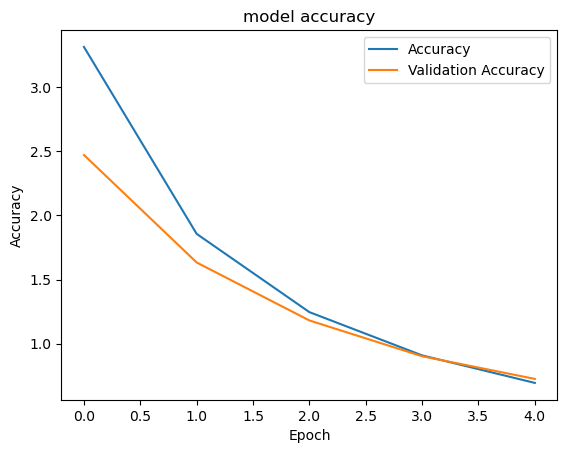

In [10]:
#plt.plot(history.history["acc"])
#plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()